# Question A3 (10 marks)

> Find the optimal depth (number of hidden layers) and width(number of neurons in each hidden layer) for the neural network designed in Question 1 and 2.

> Plot the mean cross-validation accuracies on the final epoch for at least 8 different combinations of different depth (limit to 1-3 layers) and widths (limit to 64, 128 or 256 neurons) using a scatter plot. You may consider different number of neurons for each hidden layer within an architecture. Continue using 5-fold cross validation on the training dataset. 

> Identify the architecture with the highest validation accuracy among all tested combinations. Explain the possible reasons why it performed better than the other architectures. In general, discuss whether accuracy alone is sufficient when selecting the best model. 

> Plot the train and test accuracies against training epochs for the most optimal architecture using a line plot.

> [optional + 2 marks] Implement an alternative approach that searches through these combinations that could significantly reduce the computational time but achieve similar search results, without enumeration all the possibilities.

> This might take a while to run, so plan your time carefully.

> Note: use this optimal architecture for the rest of the experiments.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

---

## 1. Paste codes from Part A_1

> To reduce repeated code, place your
> - network (MLP defined in QA1)
> - torch datasets (CustomDataset defined in QA1)
> - loss function (loss_fn defined in QA1)

> in a separate file called **common_utils.py**

> Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

> The following code cell will not be marked.

Unfortunately, the 2 methods we created in A2 cannot be reused.
- `generate_cv_folds_for_learning_rates` method: It returns a dict where each key is a learning rate. We need to create a similar (simpler) method where it only returns the lists corresponding to a specific learning rate.
- `find_optimal_hyperparameter` method: It defines a fixed model, but in this question we need to vary the hyperparameters of the model.

In [2]:
from common_utils import MLP, preprocess_dataset, intialise_loaders, train_one_epoch, evaluate

df = pd.read_csv('simplified.csv')

# Encode labels as integers
label_encoder = preprocessing.LabelEncoder()
df['label'] = df['filename'].str.split('_').str[-2]
df['label'] = label_encoder.fit_transform(df['label'])

# Prepare training data and labels
X_train: np.ndarray = df.drop(columns=['filename', 'label']).values
y_train: np.ndarray = df['label'].values

In [3]:
NUM_EPOCHS          = 200
BATCH_SIZE          = 64
NUM_FOLDS           = 5
LEARNING_RATE       = 0.0005 # Optimal from A2

---

## 2. Hyperparameter Tuning

> Perform hyperparameter tuning for different number of  hidden layers and neurons with 5-fold cross validation.

In [4]:
def generate_cv_folds (X, y, n_splits=5):
    """
    Generate cross-validation folds for the dataset.
    Args:
    - X (np.ndarray): The input features.
    - y (np.ndarray): The target labels.
    - n_splits (int): The number of folds for cross-validation.
    Returns:
    - X_train_scaled_folds (list): List of scaled training feature sets for each fold.
    - X_val_scaled_folds (list): List of scaled validation feature sets for each fold.
    - y_train_folds (list): List of training labels for each fold.
    - y_val_folds (list): List of validation labels for each fold.
    """
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    X_train_scaled_folds = []
    X_val_scaled_folds = []
    y_train_folds = []
    y_val_folds = []
    
    for train_index, test_index in kf.split(X):

        X_train_fold, X_val_fold = X[train_index], X[test_index]
        y_train_fold, y_val_fold = y[train_index], y[test_index]
        
        X_train_fold_scaled, X_test_fold_scaled = preprocess_dataset(X_train_fold, X_val_fold)

        X_train_scaled_folds.append(X_train_fold_scaled)
        X_val_scaled_folds.append(X_test_fold_scaled)
        y_train_folds.append(y_train_fold)
        y_val_folds.append(y_val_fold)

    
    return X_train_scaled_folds, X_val_scaled_folds, y_train_folds, y_val_folds

In [5]:
def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, learning_rate):
    """
    Train the model and evaluate on the validation set for a given model and set of CV folds.
    We assume that X_train_scaled, y_train2, X_val_scaled, and y_val2 are lists of numpy arrays for each fold
    
    Returns lists of training accuracies, training losses, validation accuracies, validation losses, and training times for each fold.
    """
    
    # Initialize lists to store metrics for each fold
    train_accuracies    = []
    train_losses        = []
    test_accuracies     = []
    test_losses         = []
    times               = []

    for fold in range (NUM_FOLDS):
        print (f"  Fold {fold+1}...") # 2 space

        X_train_scaled_fold = X_train_scaled[fold]
        X_val_scaled_fold   = X_val_scaled[fold]
        y_train_fold_fold   = y_train2[fold]
        y_val_fold_fold     = y_val2[fold]

        train_data_loader, val_data_loader = intialise_loaders(
            X_train_scaled_fold, 
            y_train_fold_fold, 
            X_val_scaled_fold, 
            y_val_fold_fold,
            batch_size = BATCH_SIZE
        )

        start_time = time.time()
        
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr           = learning_rate,
            weight_decay = 0.0005   
        )
        loss_fn = nn.BCELoss()

        patience            = 5             # Number of epochs to wait for improvement in test loss before stopping training

        best_train_accuracy = 0.0           # Initialize best accuracy to 0 so that any improvement will be detected
        best_train_loss     = float('inf')  # Initialize best loss to infinity so that any improvement will be detected
        best_val_accuracy   = 0.0           # Initialize best accuracy to 0 so that any improvement will be detected
        best_val_loss       = float('inf')  # Initialize best loss to infinity so that any improvement will be detected

        patience_counter    = 0             # Counter to track how many epochs have passed without improvement in test loss
        best_epoch          = 0             # To track the epoch at which the best model was saved
        
        # Evaluate the model with early stopping
        for epoch in range(NUM_EPOCHS):

            train_loss, train_acc   = train_one_epoch(model, train_data_loader, loss_fn, optimizer)
            val_loss, val_acc       = evaluate(model, val_data_loader, loss_fn)

            # Print progress every 20 epochs
            if (epoch + 1) % 20 == 0:
                print(f"    Epoch [{epoch+1}/{NUM_EPOCHS}] - " # 4 space
                    f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                    f"Test Loss: {val_loss:.4f}, Test Acc: {val_acc:.4f}") 

            # Early stopping logic
            # We use validation accuracy for early stopping
            # as we are choosing the best model based on highest validation accuracy
            if val_acc > best_val_accuracy:
                # Update best validation loss and accuracy
                best_val_loss       = val_loss
                best_val_accuracy   = val_acc

                best_train_accuracy = train_acc
                best_train_loss     = train_loss

                patience_counter    = 0
                best_epoch          = epoch
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"    Early stopping at epoch {epoch+1} for learning rate {learning_rate}") # 4 space
                break

        print (f"    Best Train Loss: {best_train_loss:.4f}, Best Train Acc: {best_train_accuracy:.4f} | "
               f"Best Test Loss: {best_val_loss:.4f}, Best Test Acc: {best_val_accuracy:.4f} at epoch {best_epoch+1}") # 4 space


        train_accuracies.append(best_train_accuracy)
        train_losses.append(best_train_loss)
        test_accuracies.append(best_val_accuracy)
        test_losses.append(best_val_loss)
        
        end_time = time.time()
        fold_time = end_time - start_time
        times.append(fold_time)

    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [6]:
def find_optimal_hyperparameter(X_train, y_train, parameters, mode, learning_rate):

    avg_test_accs   = []    # average (of all folds) train accuracies for each parameter setting
    avg_times       = []    # average (of all folds) training times for each parameter setting

    for param in parameters:
        print (f"Testing {mode} with parameters: {param}...") # 2 space

        hidden_layer_depth = param['hidden_layer_depth']
        hidden_layer_width = param['hidden_layer_width']
        input_dim = X_train.shape[1]

        model = MLP (
            num_features        = input_dim   , 
            num_hidden_layers   = hidden_layer_depth,
            hidden_widths       = [hidden_layer_width] * hidden_layer_depth,
            num_labels          = 1 ,
            dropout             = 0.3
        )

        X_train_scaled_folds, X_val_scaled_folds, y_train_folds, y_val_folds = generate_cv_folds(X_train, y_train)

        train_accuracies, train_losses, test_accuracies, test_losses, times = train(
            model, 
            X_train_scaled_folds, 
            y_train_folds, 
            X_val_scaled_folds, 
            y_val_folds, 
            learning_rate
        )

        avg_test_acc = np.mean(test_accuracies)
        avg_time     = np.mean(times)

        avg_test_accs.append(avg_test_acc)
        avg_times.append(avg_time)

        print (f"  Average Test Accuracy: {avg_test_acc:.4f}, Average Time: {avg_time:.2f} seconds\n") # 2 space

    return avg_test_accs, avg_times

We prepare 9 combinations of parameters, with 3 different depth (1, 2, 3) and 3 different width (64, 128, 256). 

We assume that for each hidden layer, the width are the same

In [7]:
parameters = []

for hidden_layer_depth in [1,2,3]:
    for hidden_layer_width in [64, 128, 256]:
        parameters.append({
            'hidden_layer_depth': hidden_layer_depth,
            'hidden_layer_width': hidden_layer_width
        })

cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train, y_train, parameters, 'architecture', LEARNING_RATE)

Testing architecture with parameters: {'hidden_layer_depth': 1, 'hidden_layer_width': 64}...
  Fold 1...
    Epoch [20/200] - Train Loss: 0.6062, Train Acc: 0.6702 | Test Loss: 0.6090, Test Acc: 0.6721
    Early stopping at epoch 29 for learning rate 0.0005
    Best Train Loss: 0.5952, Best Train Acc: 0.6768 | Best Test Loss: 0.6037, Best Test Acc: 0.6862 at epoch 24
  Fold 2...
    Early stopping at epoch 7 for learning rate 0.0005
    Best Train Loss: 0.5871, Best Train Acc: 0.6919 | Best Test Loss: 0.5501, Best Test Acc: 0.7409 at epoch 2
  Fold 3...
    Early stopping at epoch 8 for learning rate 0.0005
    Best Train Loss: 0.5682, Best Train Acc: 0.7016 | Best Test Loss: 0.5468, Best Test Acc: 0.7375 at epoch 3
  Fold 4...
    Early stopping at epoch 9 for learning rate 0.0005
    Best Train Loss: 0.5530, Best Train Acc: 0.7139 | Best Test Loss: 0.5300, Best Test Acc: 0.7491 at epoch 4
  Fold 5...
    Early stopping at epoch 6 for learning rate 0.0005
    Best Train Loss: 0.5517, 

---

## 3. Visualization

> Plot the mean cross-validation accuracies on the final epoch for at least 8 different combinations of different depth (limit to 1-3 layers) and widths (limit to 64, 128 or 256 neurons) using a scatter plot. 

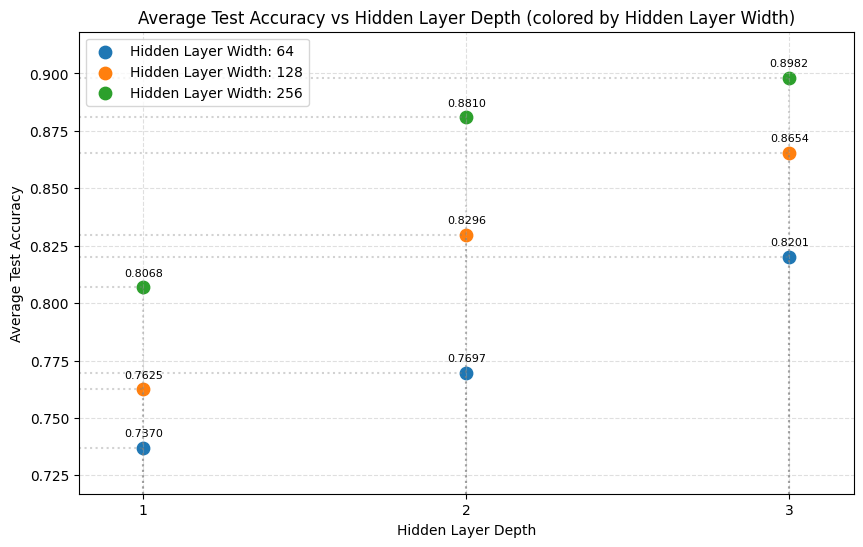

In [8]:
# Scatter plot: x = hidden layer depth, color/legend = hidden layer width
plt.figure(figsize=(10, 6))

x_min = 0.8
y_min = min(cross_validation_accuracies) - 0.02
y_max = max(cross_validation_accuracies) + 0.02

for width in sorted(set(p['hidden_layer_width'] for p in parameters)):
    depths = [p['hidden_layer_depth'] for p in parameters if p['hidden_layer_width'] == width]
    accs = [acc for acc, p in zip(cross_validation_accuracies, parameters) if p['hidden_layer_width'] == width]

    plt.scatter(depths, accs, s=80, label=f'Hidden Layer Width: {width}')

    # guide lines + accuracy label on each point
    for d, a in zip(depths, accs):
        plt.vlines(d, y_min, a, colors='gray', linestyles='dotted', alpha=0.35)
        plt.hlines(a, x_min, d, colors='gray', linestyles='dotted', alpha=0.35)
        plt.text(d, a + 0.004, f'{a:.4f}', ha='center', va='bottom', fontsize=8)

plt.xlabel('Hidden Layer Depth')
plt.ylabel('Average Test Accuracy')
plt.title('Average Test Accuracy vs Hidden Layer Depth (colored by Hidden Layer Width)')
plt.xticks([1, 2, 3])
plt.ylim(y_min, y_max)
plt.xlim(x_min, 3.2)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.show()

---

## 4. Select the optimal combination for the depth and width. State the rationale for your selection.

**Optimal Combination: 3 hidden layers with 258 neurons each**

It resulted in highest average test accuracy of 0.8982. However, we see that it is not much higher than using 2 hidden layers with 256 neurons each. The improvement may have plateaued and we need to watch out for overfitting.

---

## 5. Plot the train and test accuracies against training epochs for the most optimal architecture using a line plot.

Unfortunately we have to rewrite the code again as the previous code does not return epoch-specific information

Since we are still doing 5 fold CV, we keep track of for each fold, the accuracy at each epoch, and we take average against all folds for each epoch at the end.

And instead of early stopping, we let all folds run 40 epoch. As fold 1 ran 29 epoch and fold 2 to 5 ran 6 epoch only, we might see some overfitting / drop in accuracy with more epochs

In [9]:
HIDDEN_LAYER_DEPTH  = 3
HIDDEN_LAYER_WIDTH  = 256

NUM_EPOCHS_2        = 40

In [10]:
train_accuracies    = []    # list of accuracies for each epoch (mean of all folds) for the best hyperparameter setting
test_accuracies     = []    # list of accuracies for each epoch (mean of all folds) for the best hyperparameter setting

model = MLP (
            num_features        = X_train.shape[1]   , 
            num_hidden_layers   = HIDDEN_LAYER_DEPTH   , 
            hidden_widths       = [HIDDEN_LAYER_WIDTH] * HIDDEN_LAYER_DEPTH,
            num_labels          = 1     ,
            dropout             = 0.3
        )

X_train_scaled_folds, X_val_scaled_folds, y_train_folds, y_val_folds = generate_cv_folds(X_train, y_train)

for fold in range (NUM_FOLDS):
    print (f"  Fold {fold+1}...") # 2 space

    X_train_scaled_fold = X_train_scaled_folds[fold]
    X_val_scaled_fold = X_val_scaled_folds[fold]
    y_train_fold_fold = y_train_folds[fold]
    y_val_fold_fold = y_val_folds[fold]

    train_data_loader, val_data_loader = intialise_loaders(
        X_train_scaled_fold, 
        y_train_fold_fold, 
        X_val_scaled_fold, 
        y_val_fold_fold,
        batch_size = BATCH_SIZE
    )

    start_time = time.time()
    
    optimizer = torch.optim.Adam(
        model.parameters(), 
        lr           = LEARNING_RATE,
        weight_decay = 0.0005   
    )
    loss_fn = nn.BCELoss()

    patience            = 5             # Number of epochs to wait for improvement in test loss before stopping training

    best_train_accuracy = 0.0           # Initialize best accuracy to 0 so that any improvement will be detected
    best_train_loss     = float('inf')  # Initialize best loss to infinity so that any improvement will be detected
    best_val_accuracy   = 0.0           # Initialize best accuracy to 0 so that any improvement will be detected
    best_val_loss       = float('inf')  # Initialize best loss to infinity so that any improvement will be detected

    patience_counter    = 0             # Counter to track how many epochs have passed without improvement in test loss
    best_epoch          = 0             # To track the epoch at which the best model was saved
    
    # Evaluate the model with early stopping
    for epoch in range(NUM_EPOCHS_2):

        train_loss, train_acc   = train_one_epoch(model, train_data_loader, loss_fn, optimizer)
        val_loss, val_acc       = evaluate(model, val_data_loader, loss_fn)

        if fold == 0: # only record accuracies for the first fold to plot later
            train_accuracies.append(train_acc)
            test_accuracies.append(val_acc)

        else:
            train_accuracies[epoch] += train_acc
            test_accuracies[epoch] += val_acc


        # Print progress every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"    Epoch [{epoch+1}/{NUM_EPOCHS_2}] - " # 4 space
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
                f"Test Loss: {val_loss:.4f}, Test Acc: {val_acc:.4f}") 
            
        # No need early stopping
        if epoch == NUM_EPOCHS_2 - 1:
            best_train_accuracy = train_acc
            best_train_loss     = train_loss
            best_val_accuracy   = val_acc
            best_val_loss       = val_loss

    print (f"    Best Train Loss: {best_train_loss:.4f}, Best Train Acc: {best_train_accuracy:.4f} | "
            f"Best Test Loss: {best_val_loss:.4f}, Best Test Acc: {best_val_accuracy:.4f} at epoch {best_epoch+1}") # 4 space


  Fold 1...
    Epoch [5/40] - Train Loss: 0.6265, Train Acc: 0.6475 | Test Loss: 0.6238, Test Acc: 0.6559
    Epoch [10/40] - Train Loss: 0.5574, Train Acc: 0.7128 | Test Loss: 0.5681, Test Acc: 0.7094
    Epoch [15/40] - Train Loss: 0.4822, Train Acc: 0.7636 | Test Loss: 0.5306, Test Acc: 0.7326
    Epoch [20/40] - Train Loss: 0.4240, Train Acc: 0.8050 | Test Loss: 0.5095, Test Acc: 0.7537
    Epoch [25/40] - Train Loss: 0.3800, Train Acc: 0.8327 | Test Loss: 0.4869, Test Acc: 0.7753
    Epoch [30/40] - Train Loss: 0.3367, Train Acc: 0.8514 | Test Loss: 0.4938, Test Acc: 0.7778
    Epoch [35/40] - Train Loss: 0.3106, Train Acc: 0.8643 | Test Loss: 0.4944, Test Acc: 0.7769
    Epoch [40/40] - Train Loss: 0.2825, Train Acc: 0.8844 | Test Loss: 0.4950, Test Acc: 0.7848
    Best Train Loss: 0.2825, Best Train Acc: 0.8844 | Best Test Loss: 0.4950, Best Test Acc: 0.7848 at epoch 1
  Fold 2...
    Epoch [5/40] - Train Loss: 0.3198, Train Acc: 0.8568 | Test Loss: 0.2554, Test Acc: 0.9051
   

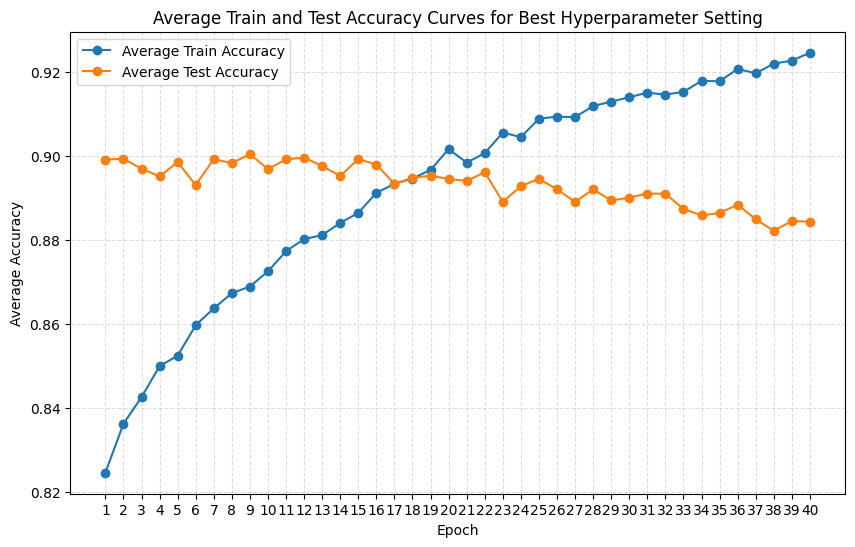

In [11]:
# Find the average accuracy across all folds for each epoch
train_accuracies = [acc / NUM_FOLDS for acc in train_accuracies]
test_accuracies = [acc / NUM_FOLDS for acc in test_accuracies]

# Plot training and validation accuracy curves
plt.figure(figsize=(10, 6))
epochs = range(1, len(train_accuracies) + 1)
plt.plot(epochs, train_accuracies, label='Average Train Accuracy', marker='o')
plt.plot(epochs, test_accuracies, label='Average Test Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Average Train and Test Accuracy Curves for Best Hyperparameter Setting')
plt.xticks(epochs)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.show()

## 6. Extra: Efficiency Improvement

> As you've astutely observed, we're facing a significant challenge in enumerating all possible combinations of widths and depths and searching over them. Given the circumstances, could you explore and implement a more efficient method for searching through these combinations that could significantly reduce the computational time but achieve similar search results?

In [12]:
# YOUR CODE HERE